In [8]:
import tensorflow as tf
import numpy
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

In [2]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    ds_train = dataset['train']
    ds_val = dataset['validation']
    ds_test = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.GAWQ11_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.GAWQ11_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.GAWQ11_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

In [ ]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [3]:
IMG_SIZE = (32, 32)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 102

In [4]:
def resize_cast(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    return image, label

base_train = dataset['train'].map(resize_cast, num_parallel_calls=tf.data.AUTOTUNE)
base_val   = dataset['validation'].map(resize_cast, num_parallel_calls=tf.data.AUTOTUNE)
base_test  = dataset['test'].map(resize_cast, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
base_train

<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Understanding Data

In [5]:
for image, label in base_train.take(1):
    print("Image shape:", image.shape)
    print("Image dtype:", image.dtype)
    print("Label:", label.numpy())

Image shape: (32, 32, 3)
Image dtype: <dtype: 'float32'>
Label: 72


In [9]:
train_count = base_train.reduce(0, lambda n, b: n + tf.shape(b[0])[0]).numpy()
val_count   = base_val.reduce(0,   lambda n, b: n + tf.shape(b[0])[0]).numpy()
test_count  = base_test.reduce(0,  lambda n, b: n + tf.shape(b[0])[0]).numpy()
print(f"Training samples: {train_count}, Validation Samples: {val_count}, Test Samples: {test_count}")


Training samples: 32640, Validation Samples: 32640, Test Samples: 196768


In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_flowers102', with_info=True)
class_names = info.features['label'].names
print("Number of classes:", len(class_names))
print("First 10 classes:", class_names[:10])


Number of classes: 102
First 10 classes: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle']


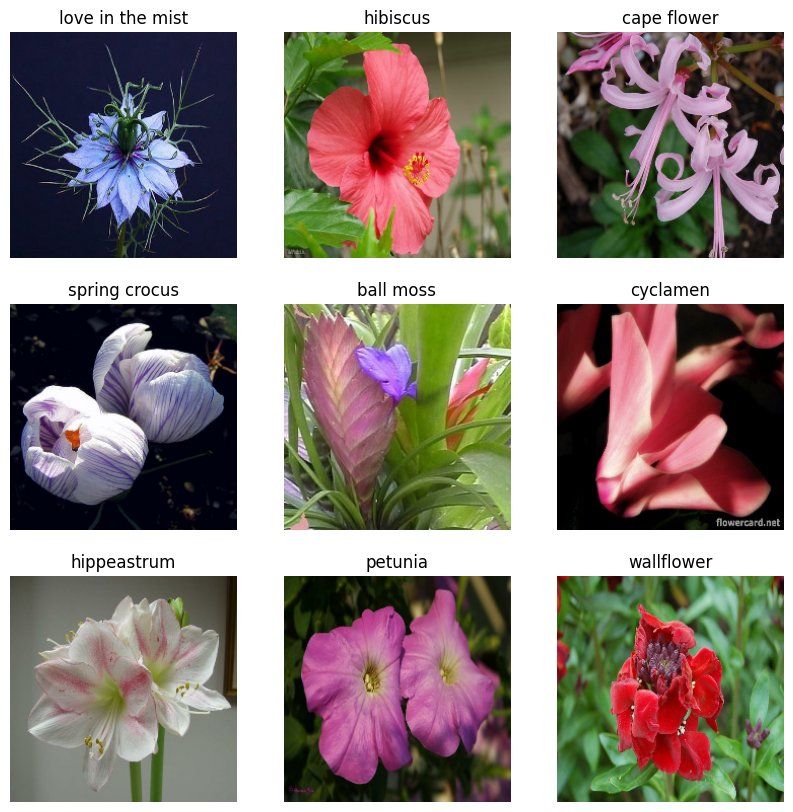

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(base_train.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()


### Data Preprocessing

In [49]:
def make_model_ds(base_ds, preprocess_fn, one_hot=False, training=False):
    def _map(image, label):
        image = tf.image.resize(image, [224, 224])
        image = preprocess_fn(image)
        return image, label
    ds = base_ds.map(_map, num_parallel_calls=AUTOTUNE)
    if training: ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [54]:
train_resnet    = make_model_ds(base_train, preprocess_resnet50, one_hot=False,  training=True)
val_resnet      = make_model_ds(base_val,   preprocess_resnet50, one_hot=False,  training=False)
test_resnet     = make_model_ds(base_test,  preprocess_resnet50, one_hot=False,  training=False)

train_vgg       = make_model_ds(base_train, preprocess_vgg16,    one_hot=False,  training=True)
val_vgg         = make_model_ds(base_val,   preprocess_vgg16,    one_hot=False,  training=False)
test_vgg        = make_model_ds(base_test,  preprocess_vgg16,    one_hot=False,  training=False)

train_mobilenet = make_model_ds(base_train, preprocess_mobilenetv2, one_hot=False, training=True)
val_mobilenet   = make_model_ds(base_val,   preprocess_mobilenetv2, one_hot=False, training=False)
test_mobilenet  = make_model_ds(base_test,  preprocess_mobilenetv2, one_hot=False, training=False)

### Model Preparation

In [60]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)

x = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)

predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

In [61]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = GlobalAveragePooling2D()(base_model_vgg16.output)

x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)

predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

In [62]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)

x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)

predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

### Fine Tuning

In [63]:
for m, base in [(model_resnet50, base_model_resnet50),
                (model_vgg16, base_model_vgg16),
                (model_mobilenetv2, base_model_mobilenetv2)]:
    base.trainable = False


model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
for layer in base_model_resnet50.layers[:-30]:
    layer.trainable = False
for layer in base_model_resnet50.layers[-30:]:
    layer.trainable = True

# VGG: last 5 layers
for layer in base_model_vgg16.layers[:-5]:
    layer.trainable = False
for layer in base_model_vgg16.layers[-5:]:
    layer.trainable = True

# MobileNetV2: last 40 layers
for layer in base_model_mobilenetv2.layers[:-40]:
    layer.trainable = False
for layer in base_model_mobilenetv2.layers[-40:]:
    layer.trainable = True

In [65]:
h_resnet_ft = model_resnet50.fit(train_resnet, validation_data=val_resnet, epochs=5)
h_vgg_ft    = model_vgg16.fit(train_vgg, validation_data=val_vgg, epochs=5)
h_mob_ft    = model_mobilenetv2.fit(train_mobilenet, validation_data=val_mobilenet, epochs=5)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 623ms/step - accuracy: 0.1327 - loss: 4.6100 - val_accuracy: 0.0304 - val_loss: 173.5388
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.6969 - loss: 1.5611 - val_accuracy: 0.0657 - val_loss: 43.9911
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.8827 - loss: 0.6097 - val_accuracy: 0.1755 - val_loss: 15.2362
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.9476 - loss: 0.3623 - val_accuracy: 0.1618 - val_loss: 13.5432
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.9722 - loss: 0.2842 - val_accuracy: 0.3284 - val_loss: 6.9047
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.0140 - loss: 6.3695 - val_accuracy: 0.0098 - val_loss: 4.6724
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step - accuracy: 0.0085 - loss: 4.7030 - val_accuracy: 0.0098 - val_loss: 4.8148
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - accuracy: 0.0067 - loss: 4.7033 - val_accuracy

### Evaluation

In [ ]:
acc_resnet50    = model_resnet50.evaluate(test_resnet)[1]
acc_vgg16       = model_vgg16.evaluate(test_vgg)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(test_mobilenet)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

193/193 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.6452 - loss: 2.0445
193/193 ━━━━━━━━━━━━━━━━━━━━ 34s 178ms/step - accuracy: 0.0173 - loss: 4.6250
193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.1403 - loss: 18.1999
ResNet50 Accuracy: 0.64
VGG16 Accuracy: 0.02
MobileNetV2 Accuracy: 0.14


In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(histories, labels):
    """
    histories: list of keras History objects
    labels: list of names (same length as histories)
    """
    plt.figure(figsize=(10,6))

    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} Train')
        plt.plot(history.history['val_accuracy'], label=f'{label} Val', linestyle='--')

    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


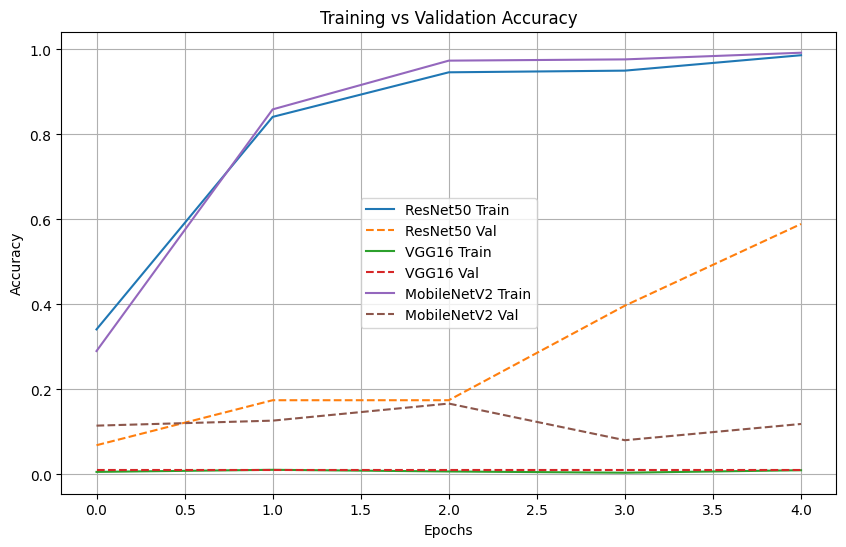

In [ ]:
plot_accuracy(
    [h_resnet_ft, h_vgg_ft, h_mob_ft],
    ["ResNet50", "VGG16", "MobileNetV2"]
)

### Summary
1. Loaded Dataset and resized

2. Preprocessed dataset according to each model

3. Prepared Model by adding new head layers

4. Trained the head layers to make them more stable

5. Trained overall model

6. Compared Accuracy and val-accuracy of each

7. VGG16 Heavy underfitting

8. MobileNetV2 Heavy Overfittingz